# Applied Data Science Capstone - Week 3 Assignment

In [1]:
import numpy as np
import pandas as pd
import requests

## Getting and cleaning up the Data

let's get the data and take a first look:

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(url)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


missing values are marked by the string 'Not assigned'. 

Change that to `NaN` for easy handling and show an overview:

In [3]:
df.replace('Not assigned', np.nan, inplace=True)
df.describe()

,Postal Code,Borough,Neighbourhood
count,180,103,103
unique,180,10,99
top,M6M,North York,Downsview
freq,1,24,4


180 rows but `Borough` and `Neighbourhood` only have 103 values, so there are some NaN's in there.

Let's drop all rows without a Borough and see if that fixes all missing values:

In [4]:
df.dropna(subset=['Borough'], inplace=True)

In [5]:
print(df.isna().sum())
df.describe()

Postal Code      0
Borough          0
Neighbourhood    0
dtype: int64


,Postal Code,Borough,Neighbourhood
count,103,103,103
unique,103,10,99
top,M6M,North York,Downsview
freq,1,24,4


They are all gone, so the missing Neighbourhoods were the same rows as the missing Boroughs and the data is cleaned up 🙂

According to assignment here is the shape:

In [6]:
df.shape

(103, 3)

## Add coordinates

In [7]:
# uncomment to download csv of coordinates by postal code
# !wget https://cocl.us/Geospatial_data

In [8]:
coords = pd.read_csv('Geospatial_data')
coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Join dataframes on the Postal Code:

In [9]:
df = df.join(coords.set_index('Postal Code'), on='Postal Code')
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


To make sure that nothing unexpected happend I check that the number of rows ist still 103 and no new NaN's show up:

In [10]:
print(df.shape)
print(df.isna().sum())

(103, 5)
Postal Code      0
Borough          0
Neighbourhood    0
Latitude         0
Longitude        0
dtype: int64


## First Look at a Map

In [11]:
# !pip3 install folium
import folium

In [12]:
# use the mean of all locations to find a good point for the map to start at
lat_mean = df['Latitude'].mean()
long_mean = df['Longitude'].mean()

Let's take a look at how out data is distributed over space

In [13]:
# create map
map_to = folium.Map(location=[lat_mean, long_mean], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Postal Code']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_to)  
    
map_to

I will perform the clustring on all of toronto instead of just the inner Boroughs. I hope to see more diverse areas this way.

## Getting Venue Data from Foursquare

In [14]:
CLIENT_ID = 'YOURCLIENTID' # your Foursquare ID
CLIENT_SECRET = 'YOURSECRET' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

I will use the function from the previous lab to get the venues from the foursquare API and convert them into a dataframe

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Postal Code Latitude', 
                  'Postal Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
df_venues = getNearbyVenues(names=df['Postal Code'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'])

M3A
M4A
M5A
M6A
M7A
M9A
M1B
M3B
M4B
M5B
M6B
M9B
M1C
M3C
M4C
M5C
M6C
M9C
M1E
M4E
M5E
M6E
M1G
M4G
M5G
M6G
M1H
M2H
M3H
M4H
M5H
M6H
M1J
M2J
M3J
M4J
M5J
M6J
M1K
M2K
M3K
M4K
M5K
M6K
M1L
M2L
M3L
M4L
M5L
M6L
M9L
M1M
M2M
M3M
M4M
M5M
M6M
M9M
M1N
M2N
M3N
M4N
M5N
M6N
M9N
M1P
M2P
M4P
M5P
M6P
M9P
M1R
M2R
M4R
M5R
M6R
M7R
M9R
M1S
M4S
M5S
M6S
M1T
M4T
M5T
M1V
M4V
M5V
M8V
M9V
M1W
M4W
M5W
M8W
M9W
M1X
M4X
M5X
M8X
M4Y
M7Y
M8Y
M8Z


## Exploring the Venue Data

In [17]:
df_venues

,Postal Code,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,TTC stop #8380,43.752672,-79.326351,Bus Stop
2,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,M4A,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
...,...,...,...,...,...,...,...
2103,M8Z,43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
2104,M8Z,43.628841,-79.520999,Once Upon A Child,43.631075,-79.518290,Kids Store
2105,M8Z,43.628841,-79.520999,Value Village,43.631269,-79.518238,Thrift / Vintage Store
2106,M8Z,43.628841,-79.520999,Kingsway Boxing Club,43.627254,-79.526684,Gym


Alright, 2108 venues in total this is way less dense than Manhatten which is to be expected but still a good amount of data for clustering.

How do those distribute over Postal Codes?

array([[<AxesSubplot:title={'center':'Venue'}>]], dtype=object)

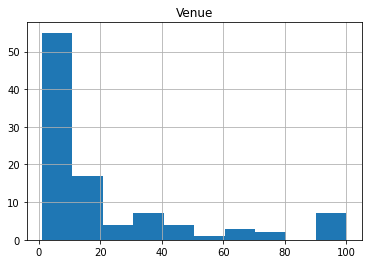

In [18]:
df_venues.groupby('Postal Code').count().hist('Venue')

So most areas don't have a lot of venues but some have lot. Makes sense! I'd like to see a list of the frontrunners:

In [19]:
venue_count = df_venues.groupby('Postal Code').count().sort_values('Venue', ascending=False).reset_index()
venue_count.head(15)

,Postal Code,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5X,100,100,100,100,100,100
1,M5B,100,100,100,100,100,100
2,M5L,100,100,100,100,100,100
3,M5K,100,100,100,100,100,100
4,M5J,100,100,100,100,100,100
5,M5W,99,99,99,99,99,99
6,M5H,93,93,93,93,93,93
7,M5C,80,80,80,80,80,80
8,M4Y,80,80,80,80,80,80
9,M5T,68,68,68,68,68,68


It's almost all "M5"-Codes which also makes sense, because (as we can verify with the map we rendered earlier) this corresponds to the city centre. How about color coding these on a map?

In [20]:
density = venue_count[['Postal Code', 'Venue']].join(coords.set_index('Postal Code'), on='Postal Code')
density.head()

,Postal Code,Venue,Latitude,Longitude
0,M5X,100,43.648429,-79.382280
1,M5B,100,43.657162,-79.378937
2,M5L,100,43.648198,-79.379817
3,M5K,100,43.647177,-79.381576
4,M5J,100,43.640816,-79.381752


In [21]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [22]:
# create map
map_density = folium.Map(location=[lat_mean, long_mean], zoom_start=11)

norm = colors.Normalize(vmin=0, vmax=LIMIT)
cmap = cm.get_cmap('YlOrRd')

# add markers to map
for lat, lng, label, venues in zip(density['Latitude'], density['Longitude'], density['Postal Code'], density['Venue']):
    label = folium.Popup(label + f'\n{venues}', parse_html=True)
    my_color = colors.rgb2hex(cmap(norm(venues)))
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='black',
        weight=2,
        fill=True,
        fill_color=my_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_density)
    
map_density

so this visualizations shows where the venues concentrate, very nice!

## Clustering

In [23]:
df_venues

,Postal Code,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,TTC stop #8380,43.752672,-79.326351,Bus Stop
2,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,M4A,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
...,...,...,...,...,...,...,...
2103,M8Z,43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon
2104,M8Z,43.628841,-79.520999,Once Upon A Child,43.631075,-79.518290,Kids Store
2105,M8Z,43.628841,-79.520999,Value Village,43.631269,-79.518238,Thrift / Vintage Store
2106,M8Z,43.628841,-79.520999,Kingsway Boxing Club,43.627254,-79.526684,Gym


How many categories do wa have?

In [24]:
unique_cats = len(df_venues['Venue Category'].unique())
print(f'There are {unique_cats} uniques categories.')

There are 276 uniques categories.


Convert them into One Hot Coding

In [25]:
# one hot encoding
onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Postal Code'] = df_venues['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Postal Code,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group them together by Postal Code

In [26]:
grouped = onehot.groupby('Postal Code').mean().reset_index()
grouped

,Postal Code,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,M9N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,M9P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,M9R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,M9V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
grouped.shape

(100, 277)

Top 5 Categories for all Areas:

In [28]:
num_top_venues = 5

for code in grouped['Postal Code'].sort_values():
    print("----"+code+"----")
    temp = grouped[grouped['Postal Code'] == code].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M1B----
                             venue  freq
0             Fast Food Restaurant   0.5
1                       Print Shop   0.5
2               Mexican Restaurant   0.0
3              Monument / Landmark   0.0
4  Molecular Gastronomy Restaurant   0.0


----M1C----
                        venue  freq
0  Construction & Landscaping  0.67
1                         Bar  0.33
2           Accessories Store  0.00
3   Middle Eastern Restaurant  0.00
4         Monument / Landmark  0.00


----M1E----
                 venue  freq
0  Rental Car Location  0.12
1       Medical Center  0.12
2       Breakfast Spot  0.12
3                 Bank  0.12
4         Intersection  0.12


----M1G----
                             venue  freq
0                      Coffee Shop  0.67
1            Korean BBQ Restaurant  0.33
2                Accessories Store  0.00
3              Monument / Landmark  0.00
4  Molecular Gastronomy Restaurant  0.00


----M1H----
                  venue  freq
0   Fried Chicken Jo

            venue  freq
0     Coffee Shop  0.16
1            Park  0.07
2          Bakery  0.07
3         Theater  0.05
4  Breakfast Spot  0.05


----M5B----
                venue  freq
0      Clothing Store  0.09
1         Coffee Shop  0.08
2  Italian Restaurant  0.03
3                Café  0.03
4     Bubble Tea Shop  0.03


----M5C----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.06
2            Gastropub  0.04
3         Cocktail Bar  0.04
4  American Restaurant  0.04


----M5E----
          venue  freq
0   Coffee Shop  0.09
1  Cocktail Bar  0.05
2        Bakery  0.05
3      Pharmacy  0.03
4      Beer Bar  0.03


----M5G----
                venue  freq
0         Coffee Shop  0.18
1  Italian Restaurant  0.05
2                Café  0.05
3      Sandwich Place  0.05
4         Salad Place  0.03


----M5H----
           venue  freq
0    Coffee Shop  0.11
1           Café  0.05
2     Restaurant  0.04
3         Bakery  0.03
4  Deli / Bodega  0.03


----

                             venue  freq
0                             Park   1.0
1                Accessories Store   0.0
2                    Metro Station   0.0
3  Molecular Gastronomy Restaurant   0.0
4       Modern European Restaurant   0.0


----M9P----
                       venue  freq
0                Pizza Place  0.25
1             Sandwich Place  0.12
2               Intersection  0.12
3         Chinese Restaurant  0.12
4  Middle Eastern Restaurant  0.12


----M9R----
                 venue  freq
0          Pizza Place  0.25
1       Sandwich Place  0.25
2             Bus Line  0.25
3    Mobile Phone Shop  0.25
4  Moroccan Restaurant  0.00


----M9V----
                 venue  freq
0        Grocery Store  0.22
1          Pizza Place  0.11
2             Pharmacy  0.11
3           Beer Store  0.11
4  Fried Chicken Joint  0.11


----M9W----
                 venue  freq
0        Garden Center  0.25
1                  Bar  0.25
2  Rental Car Location  0.25
3            Drugstore  

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
areas_venues_sorted = pd.DataFrame(columns=columns)
areas_venues_sorted['Postal Code'] = grouped['Postal Code']

for ind in np.arange(grouped.shape[0]):
    areas_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

areas_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Fast Food Restaurant,Print Shop,Mexican Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Accessories Store
1,M1C,Construction & Landscaping,Bar,Accessories Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Mexican Restaurant
2,M1E,Rental Car Location,Medical Center,Breakfast Spot,Bank,Intersection,Mexican Restaurant,Electronics Store,Restaurant,Accessories Store,Molecular Gastronomy Restaurant
3,M1G,Coffee Shop,Korean BBQ Restaurant,Accessories Store,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant
4,M1H,Fried Chicken Joint,Bank,Gas Station,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Bakery,Hakka Restaurant,Metro Station,Mexican Restaurant


In [31]:
#!pip3 install sklearn
from sklearn.cluster import KMeans

In [32]:
# set number of clusters
kclusters = 5

grouped_clustering = grouped.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 2, 2, 2, 4, 2, 2, 2, 2], dtype=int32)

In [33]:
# add clustering labels
areas_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged = df

# merge grouped with data to add latitude/longitude for each neighborhood
merged = merged.join(areas_venues_sorted.set_index('Postal Code'), on='Postal Code')

merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Bus Stop,Park,Food & Drink Shop,Accessories Store,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
3,M4A,North York,Victoria Village,43.725882,-79.315572,3.0,Pizza Place,Intersection,French Restaurant,Hockey Arena,Portuguese Restaurant,Coffee Shop,Miscellaneous Shop,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2.0,Coffee Shop,Park,Bakery,Theater,Breakfast Spot,Pub,Restaurant,Café,Yoga Studio,Shoe Store
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2.0,Clothing Store,Accessories Store,Event Space,Boutique,Furniture / Home Store,Miscellaneous Shop,Coffee Shop,Vietnamese Restaurant,Sporting Goods Shop,Men's Store
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Theater,Smoothie Shop,Mexican Restaurant,Café,Fried Chicken Joint,Sandwich Place,Beer Bar


In [34]:
merged.dropna(inplace=True)
print(merged.isna().sum())
merged.describe()

Postal Code               0
Borough                   0
Neighbourhood             0
Latitude                  0
Longitude                 0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64


,Latitude,Longitude,Cluster Labels
count,100.000000,100.000000,100.000000
mean,43.703131,-79.397942,2.020000
std,0.051156,0.095723,0.635324
min,43.602414,-79.615819,0.000000
25%,43.659132,-79.464763,2.000000
50%,43.696633,-79.389142,2.000000
75%,43.740746,-79.340923,2.000000
max,43.815252,-79.160497,4.000000


In [35]:
# create map
map_clusters = folium.Map(location=[lat_mean, long_mean], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster, code, bor, hood in zip(merged['Latitude'], merged['Longitude'], merged['Cluster Labels'], merged['Postal Code'], merged['Borough'], merged['Neighbourhood']):
    label = folium.Popup(f"{code}: {hood}\n\n{bor}\n\nCluster: {str(int(cluster))}", parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

## Examine Clusters

### Cluster 1

In [36]:
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Scarborough,0.0,Construction & Landscaping,Bar,Accessories Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Mexican Restaurant
83,North York,0.0,Business Service,Baseball Field,Food Truck,Accessories Store,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Mexican Restaurant
89,North York,0.0,Baseball Field,Accessories Store,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Metro Station,Moroccan Restaurant
169,Etobicoke,0.0,Construction & Landscaping,Baseball Field,Accessories Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Mexican Restaurant


### Cluster 2

In [37]:
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,York,1.0,Park,Women's Store,Accessories Store,Men's Store,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Metro Station
65,North York,1.0,Airport,Park,Accessories Store,Metro Station,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant
82,North York,1.0,Park,Accessories Store,Metro Station,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Men's Store
98,York,1.0,Park,Accessories Store,Metro Station,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant,Men's Store
100,North York,1.0,Park,Convenience Store,Accessories Store,Mexican Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
147,Downtown Toronto,1.0,Park,Trail,Playground,Accessories Store,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant


### Cluster 3

In [38]:
merged.loc[merged['Cluster Labels'] == 2, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,North York,2.0,Bus Stop,Park,Food & Drink Shop,Accessories Store,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
4,Downtown Toronto,2.0,Coffee Shop,Park,Bakery,Theater,Breakfast Spot,Pub,Restaurant,Café,Yoga Studio,Shoe Store
5,North York,2.0,Clothing Store,Accessories Store,Event Space,Boutique,Furniture / Home Store,Miscellaneous Shop,Coffee Shop,Vietnamese Restaurant,Sporting Goods Shop,Men's Store
6,Downtown Toronto,2.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Theater,Smoothie Shop,Mexican Restaurant,Café,Fried Chicken Joint,Sandwich Place,Beer Bar
11,North York,2.0,Japanese Restaurant,Caribbean Restaurant,Gym,Café,Mobile Phone Shop,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
157,Downtown Toronto,2.0,Coffee Shop,Café,Hotel,Gym,Japanese Restaurant,Restaurant,Asian Restaurant,Steakhouse,Seafood Restaurant,Salad Place
160,Etobicoke,2.0,River,Pool,Accessories Store,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Metro Station
165,Downtown Toronto,2.0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Yoga Studio,Men's Store,Pub,Fast Food Restaurant,Café
168,East Toronto,2.0,Park,Recording Studio,Smoke Shop,Fast Food Restaurant,Skate Park,Burrito Place,Spa,Farmers Market,Butcher,Light Rail Station


### Cluster 4

In [39]:
merged.loc[merged['Cluster Labels'] == 3, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,North York,3.0,Pizza Place,Intersection,French Restaurant,Hockey Arena,Portuguese Restaurant,Coffee Shop,Miscellaneous Shop,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
9,Scarborough,3.0,Fast Food Restaurant,Print Shop,Mexican Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Accessories Store
12,East York,3.0,Pizza Place,Pharmacy,Pet Store,Gym / Fitness Center,Flea Market,Gastropub,Intersection,Bank,Athletics & Sports,Mobile Phone Shop
74,North York,3.0,Grocery Store,Shopping Mall,Park,Bank,Accessories Store,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Mexican Restaurant
80,North York,3.0,Pizza Place,Intersection,Mexican Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Metro Station
92,North York,3.0,Athletics & Sports,Gym / Fitness Center,Grocery Store,Discount Store,Accessories Store,Middle Eastern Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop
95,York,3.0,Pizza Place,Convenience Store,Brewery,Mexican Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant
107,Etobicoke,3.0,Pizza Place,Sandwich Place,Intersection,Chinese Restaurant,Middle Eastern Restaurant,Coffee Shop,Discount Store,Modern European Restaurant,Moroccan Restaurant,Monument / Landmark
109,North York,3.0,Pizza Place,Grocery Store,Supermarket,Discount Store,Coffee Shop,Pharmacy,Mediterranean Restaurant,Medical Center,Men's Store,Metro Station
116,Etobicoke,3.0,Pizza Place,Sandwich Place,Bus Line,Mobile Phone Shop,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop,Accessories Store


### Cluster 5

In [40]:
merged.loc[merged['Cluster Labels'] == 4, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Scarborough,4.0,Playground,Mexican Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Middle Eastern Restaurant,Metro Station,Luggage Store
